# Verursacht Temu eine Erhöhung von Frachtflüfgen von China nach Europa?

Max Köhler/SWR DataLab (max.koehler@swr.de), 1. Oktober 2024 (Aktualisiert 8. Oktober 2024)


In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

In [3]:
# Proprietary flight data
flights_2019 = pd.read_csv("./data/20190825-20190901.csv", parse_dates=["date"])
flights_2020 = pd.read_csv("./data/20200825-20200901.csv", parse_dates=["date"])
flights_2021 = pd.read_csv("./data/20210825-20210901.csv", parse_dates=["date"])
flights_2022 = pd.read_csv("./data/20220825-20220901.csv", parse_dates=["date"])
flights_2023 = pd.read_csv("./data/20230825-20230901.csv", parse_dates=["date"])
flights_2024 = pd.read_csv("./data/20240825-20240901.csv", parse_dates=["date"])
flights = pd.concat([flights_2019, flights_2020, flights_2021, flights_2022, flights_2023, flights_2024]).reset_index()

# Public domain airport data (https://ourairports.com/data/)
airports = pd.read_csv("./data/airports.csv")

In [4]:
flights.shape[0]
del flights["index"]

In [5]:
# Drop airports without IATA codes
airports = airports.drop(
    airports[
        (airports["iata_code"].isnull())
     	| (airports["iata_code"] == "nan")
  	].index)

# Select landing events with destination IATA Codes
landings = flights[
			(flights["destination_iata"].notnull())
    & (flights["event"] == "landed")
        ].reset_index(drop=True)

print(f"{landings.shape[0]} landings found.")

landings

1706121 landings found.


,address,altitude,callsign,date,destination_iata,destination_icao,equipment,event,flight,flight_id,latitude,longitude,operator,origin_iata,origin_icao,registration,time
0,4071C7,0,CLU602,2019-08-25,FRA,EDDF,B744,landed,P3602,567409317,50.03130,8.54998,CLU,DFW,KDFW,G-CLBA,05:45:56
1,7807BC,0,CSN327,2019-08-25,LAX,KLAX,A388,landed,CZ327,567430086,33.95010,-118.42200,NaN,CAN,ZGGG,B-6138,02:17:49
2,8A0579,100,GIA089,2019-08-25,CGK,WIII,B77W,landed,GA89,567442785,-6.10821,106.67100,GIA,AMS,EHAM,PK-GIK,00:51:37
3,7C8068,0,QFA9,2019-08-25,LHR,EGLL,B789,landed,QF9,567442973,51.47760,-0.45959,QFA,PER,YPPH,VH-ZNE,03:51:33
4,7C8064,0,QFA10,2019-08-25,PER,YPPH,B789,landed,QF10,567445066,-31.96200,115.95900,QFA,LHR,EGLL,VH-ZNA,03:49:41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1706116,3464CD,400,EAX6KS,2024-08-31,GRO,LEGE,P208,landed,NaN,921103821,41.91382,2.76536,AEP,GRO,LEGE,EC-NJC,23:48:43
1706117,78176C,0,B7911,2024-08-31,MIG,ZUMY,C172,landed,B7911,921104503,31.42937,104.74034,NaN,MIG,ZUMY,B-7911,23:49:43
1706118,781787,0,B7917,2024-08-31,MIG,ZUMY,C172,landed,B7917,921104797,31.42449,104.74711,NaN,MIG,ZUMY,B-7917,23:59:38
1706119,4844C2,0,LIFLN3,2024-08-31,UDE,EHVK,EC35,landed,NaN,921105019,51.65263,5.69314,NaN,UDE,EHVK,PH-MAA,23:49:34


In [6]:
# Merge airports on destination_iata
merged_flights = pd.merge(
	landings,
	airports[["iata_code", "iso_country"]],
	how="left",
	left_on=["destination_iata"],
	right_on="iata_code").drop("iata_code", axis=1)

merged_flights["destination_country"] = merged_flights["iso_country"]
merged_flights.drop("iso_country", axis=1, inplace=True)

# Merge airports on origin_iata
merged_flights = pd.merge(
	merged_flights,
	airports[["iata_code", "iso_country"]],
	how="left",
	left_on=["origin_iata"],
	right_on="iata_code").drop("iata_code", axis=1)

merged_flights["origin_country"] = merged_flights["iso_country"]
merged_flights.drop("iso_country", axis=1, inplace=True)

missed_destination = merged_flights.loc[merged_flights["destination_country"].isnull()].shape[0]
missed_origin = merged_flights.loc[merged_flights["origin_country"].isnull()].shape[0]

print(f'Failed to set origin country for {missed_origin} flights ({round(missed_origin / landings.shape[0] * 100, 2)}%) and destination country for {missed_destination} flights ({round(missed_destination / landings.shape[0] * 100, 2)}%),\nlikely because their IATA codes are missing from our airport data.')

Failed to set origin country for 132085 flights (7.74%) and destination country for 45667 flights (2.68%),
likely because their IATA codes are missing from our airport data.


In [7]:
eu_countries = ("BG", "HR", "CY", "CZ", "DK", "EE", "FI", "FR", "DE", "GR", "HU", "IE", "LV", "LT", "LU", "MT", "NL", "PL", "PT", "RO", "SK", "SI", "ES", "SE")

# Flights from any Chinese airport that landed in any EU airport
flights_china_eu = merged_flights.loc[
    (merged_flights["origin_country"] == "CN")
    & (merged_flights["destination_country"].isin(eu_countries))]

years = [2019, 2020, 2021, 2022, 2023, 2024]

results = pd.DataFrame()

for y in years:
    result = pd.DataFrame({"year": [y]})
    year_flights = flights_china_eu.loc[flights_china_eu["date"].dt.year == y]
    for c in eu_countries:
    	result[c] = year_flights.loc[year_flights["destination_country"] == c].shape[0]

    result["total"] = year_flights.shape[0]
    results = pd.concat([results, result], ignore_index=True)
    
results["change_to_prev"] = results["total"].divide(results["total"].shift(periods=1)).add(-1)
results

,year,BG,HR,CY,CZ,DK,EE,FI,FR,DE,...,NL,PL,PT,RO,SK,SI,ES,SE,total,change_to_prev
0,2019,0,0,0,10,20,0,37,98,138,...,75,7,1,0,0,0,25,11,443,NaN
1,2020,0,0,0,0,2,0,8,17,44,...,45,1,2,0,0,0,6,2,141,-0.681716
2,2021,0,0,0,0,5,0,5,26,57,...,31,3,1,0,0,0,6,1,143,0.014184
3,2022,1,0,0,0,6,0,7,27,66,...,40,1,1,0,0,0,3,0,164,0.146853
4,2023,0,0,0,0,6,0,11,58,112,...,61,8,2,0,0,0,18,3,303,0.847561
5,2024,0,0,0,3,9,0,12,71,139,...,75,6,2,0,0,0,40,14,413,0.363036


## Ergebnisse

### Welche Daten liegen vor?

Die beiden CSV-Dateien enthalten Daten für weltweite, von FlightRadar24 erfasste Flüge im Zeitraum 25-31 August für alle Jahre 2019-2024. Jeder Flug ist durch zwei Zeilen repräsentiert, eine für den Start (`takeoff`) und die Landung (`landing`). Der Datensatz enthält insgesamt 155012 solche Zeilen, was den [Industriezahlen für Flüge 2019-2024](https://www.iata.org/en/iata-repository/publications/economic-reports/global-outlook-for-air-transport-june-2024-report/) entspricht. Sanity check: $180.700.000 / (52 * 6) * 6 = 1.158.334 \approx 1.031.482$).

Zu jedem Flug werden eine Reihe von mehr oder weniger interessanten Metadaten angegeben. Die Spalten `origin_iata` und `destination_iata` sind Flughafen-Codes die wir relativ leicht Ländern oder Regionen zuordnen können (siehe oben).

Lufthansa 721 von Beijing Capital International Airport (`PEK`) nach Frankfurt (`FRA`) am 25.8.2019 ist zum Beispiel so repräsentiert:


In [8]:
flights.loc[(flights["flight_id"] == 567604177)]

,address,altitude,callsign,date,destination_iata,destination_icao,equipment,event,flight,flight_id,latitude,longitude,operator,origin_iata,origin_icao,registration,time
7584,3C4B30,1850,DLH721,2019-08-25,FRA,EDDF,B748,takeoff,LH721,567604177,40.1414,116.62600,DLH,PEK,ZBAA,D-ABYP,02:50:33
7585,3C4B30,0,DLH721,2019-08-25,FRA,EDDF,B748,landed,LH721,567604177,50.0355,8.56753,DLH,PEK,ZBAA,D-ABYP,12:16:16


### Enthält der Datensatz nur Flüge von Europa nach China, oder auch Flüge von China nach Europa?

**Ja**. Der Datensatz enthält Flüge aus allen Ländern in alle Länder (inkl. Binnenflüge), also sowohl Flüge von China nach Europa and auch von Europa nach China. Wir können die interessanten Flüge leicht herausfiltern.


### Beinhaltet der Datensatz alle Flüge, sowohl Luftfrachtflüge als auch Passagierflüge?

**Ja**. Der Datensatz enthält alle welteweiten Flüge in den angegebenen Zeiträumen und es gibt keine offensichtliche Unterscheidung zwischen Passagier- und Frachtflügen. Möglicherweise kann man Frachtflüge am `operator` erkennen (zb. `GEC` für Lufthansa Cargo), aber ich weiß nicht wie präzise diese Unterscheidung wäre.


### Kann man an den Daten erhöhten Flugverkehr durch Temu erkennen?

**Nicht wirklich**: Zwischen dem Start von Temu in 2023 und 2024 ist die Zahl der Flüge von China nach Europa um 36.3% gestiegen, aber mir ist nicht klar ob ein kausaler Zusammenhang besteht. In detaillierteren Daten (höhere Zeitauflösung und Unterscheidung zwischen Passenger/Cargo) könnte man den Zusammenhang vielleicht besser sehen.


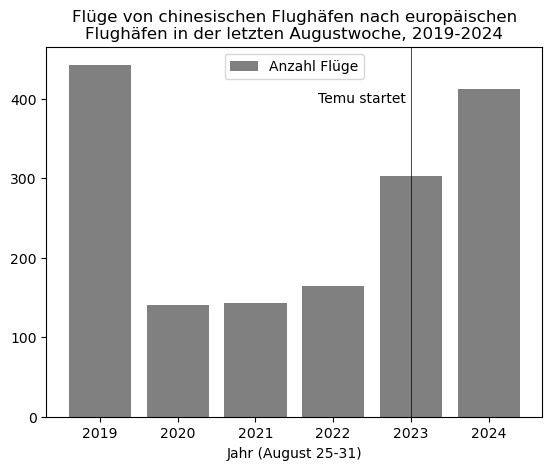

In [12]:
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

days = pd.DataFrame(pd.date_range(start='7/1/2019', end='10/1/2024', freq="W", name="date"))
flights_per_year = flights_china_eu.groupby(landings.date.dt.year).size()

labels = pd.DataFrame([
	{"year": 2023, "text": "Temu startet", "y_offset": 0, "source": "https://www.reuters.com/technology/chinese-owned-e-commerce-platform-temu-expands-europe-2023-04-25/"},
])

fig,ax = plt.subplots()
ax.set_title("Flüge von chinesischen Flughäfen nach europäischen\nFlughäfen in der letzten Augustwoche, 2019-2024")
ax.bar(
	x=flights_per_year.index,
	height=flights_per_year.values,
	label="Anzahl Flüge",
	color="gray"
)
ax.xaxis.set_major_locator(locator)
ax.set_xlabel("Jahr (August 25-31)")
ax.legend()

for index, l in labels.iterrows():
	ax.axvline(x=l["year"], color="black", lw=.5, zorder=10)
	ax.annotate(
		zorder=200,
		text=l["text"],
		xy=(l["year"], 0),
		horizontalalignment="right",
		textcoords=("data","axes fraction"),
		xytext=(l["year"] - .065,.85 + l["y_offset"])
	)

plt.show()